# Privacy Meter Demo: Range Membership Inference (RaMIA)

This notebook is an interactive demonstration of running Privacy Meter to audit privacy defined by **RaMIA**. For a detailed explanation on RaMIA and how to run from bash, please refer to the [documentation](documentation/ramia.md)

## Setting up the Colab environment

If you are running it offline, you can skip to "Importing"

In [ ]:
# Clone the github repo
!git clone https://github.com/privacytrustlab/ml_privacy_meter.git

# Update the Colab environment
!pip install datasets==2.21.0 transformers==4.44.2 torch==2.4.1 torchvision==0.19.1 torchaudio

In [ ]:
# Change the directory to the cloned repo
import sys
sys.path.append('/content/ml_privacy_meter')

%cd ml_privacy_meter

/content/ml_privacy_meter


## Importing

In [1]:
import math
import time

import numpy as np
import torch
import yaml
from torch.utils.data import Subset
import matplotlib.pyplot as plt

%matplotlib inline

from audit import get_average_audit_results, audit_models_range, sample_auditing_dataset
from dataset.range_dataset import RangeDataset, RangeSampler
from get_signals import get_model_signals
from models.utils import load_models, train_models, split_dataset_for_training
from util import (
    check_configs,
    setup_log,
    initialize_seeds,
    create_directories,
    load_dataset,
)

# Enable benchmark mode in cudnn to improve performance when input sizes are consistent
torch.backends.cudnn.benchmark = True

/home/jiashu/anaconda3/envs/privacy_meter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load config

In [2]:
configs = "configs/ramia/cifar10.yaml"
with open(configs, "rb") as f:
        configs = yaml.load(f, Loader=yaml.Loader)

# Validate configurations
check_configs(configs)

**Using other range functions**: You can change the configuration to run Privacy Meter with different settings (e.g. range functions) by directly modifying the respective `config` fields


In [ ]:
configs["ramia"]["range_function"] = "l2"

## Setting up

In [3]:
# Validate configurations
check_configs(configs)

# Initialize seeds for reproducibility
initialize_seeds(configs["run"]["random_seed"])

# Create necessary directories
log_dir = configs["run"]["log_dir"]
directories = {
    "log_dir": log_dir,
    "report_dir": f"{log_dir}/report_ramia",
    "signal_dir": f"{log_dir}/signals",
    "data_dir": configs["data"]["data_dir"],
}
create_directories(directories)

# Set up logger
logger = setup_log(
    directories["report_dir"], "time_analysis", configs["run"]["time_log"]
)

start_time = time.time()

## Load dataset

In [4]:
baseline_time = time.time()
dataset, population = load_dataset(configs, directories["data_dir"], logger)
logger.info("Loading dataset took %0.5f seconds", time.time() - baseline_time)

2025-02-06 12:31:11,199 INFO     Data loaded from data/cifar10.pkl
2025-02-06 12:31:11,220 INFO     Population data loaded from data/cifar10_population.pkl
2025-02-06 12:31:11,221 INFO     The whole dataset size: 50000
2025-02-06 12:31:11,221 INFO     Loading dataset took 0.08245 seconds


## Load or train models

In [5]:
# Define experiment parameters
num_experiments = configs["run"]["num_experiments"]
num_reference_models = configs["audit"]["num_ref_models"]
num_model_pairs = max(math.ceil(num_experiments / 2.0), num_reference_models + 1)

# Load or train models
baseline_time = time.time()
models_list, memberships = load_models(
    log_dir, dataset, num_model_pairs * 2, configs, logger
)
if models_list is None:
    # Split dataset for training two models per pair
    data_splits, memberships = split_dataset_for_training(
        len(dataset), num_model_pairs
    )
    models_list = train_models(
        log_dir, dataset, data_splits, memberships, configs, logger
    )
logger.info(
    "Model loading/training took %0.1f seconds", time.time() - baseline_time
)


2025-02-06 12:31:11,227 INFO     Loading model 0
2025-02-06 12:31:11,381 INFO     Loading model 1
2025-02-06 12:31:11,420 INFO     Loading model 2
2025-02-06 12:31:11,460 INFO     Loading model 3
2025-02-06 12:31:11,499 INFO     Model loading/training took 0.3 seconds


## Create range dataset

In [6]:
logger.info("Creating range dataset.")
dataset = RangeDataset(
    dataset,
    RangeSampler(
        range_fn=configs["ramia"]["range_function"],
        sample_size=configs["ramia"]["sample_size"],
        config=configs,
    ),
    configs,
)
logger.info("Range dataset has been created")

2025-02-06 12:31:11,505 INFO     Creating range dataset.
2025-02-06 12:31:11,506 INFO     Range dataset has been created


## Prepare auditing dataset

In [7]:
auditing_dataset, auditing_membership = sample_auditing_dataset(
        configs, dataset, logger, memberships
    )

# Also downsample the population set size if specified in the config
population = Subset(
    population,
    np.random.choice(
        len(population),
        configs["audit"].get("population_size", len(population)),
        replace=False,
    ),
)

2025-02-06 12:31:11,516 INFO     Downsampling the dataset for auditing to 10000 samples. The numbers of members and non-members are only guaranteed to be equal for the first target model, if more than one are used.


## Compute signals

In [8]:
baseline_time = time.time()
signals = get_model_signals(models_list, auditing_dataset, configs, logger)
population_signals = get_model_signals(
    models_list, population, configs, logger, is_population=True
)
logger.info("Preparing signals took %0.5f seconds", time.time() - baseline_time)

2025-02-06 12:31:11,528 INFO     Signals loaded from disk successfully.
2025-02-06 12:31:11,529 WARNING  Signals shape (10000) does not match the expected size (40000). This mismatch is likely due to a change in the training data size multiplied by ramia sample size (4).
2025-02-06 12:31:11,529 INFO     Ignoring the signals on disk and recomputing.
2025-02-06 12:31:12,523 INFO     Computing signals for all models.
Computing softmax: 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]
2025-02-06 12:31:14,777 INFO     Signals saved to disk.
2025-02-06 12:31:14,781 INFO     Preparing signals took 3.25358 seconds


## Computing range TPR and FPR and aggregate the auditing result

In [9]:
# Perform the privacy audit
baseline_time = time.time()
target_model_indices = list(range(num_experiments))
mia_score_list, membership_list = audit_models_range(
        f"{directories['report_dir']}/exp",
        target_model_indices,
        signals,
        population_signals,
        np.repeat(auditing_membership, configs["ramia"]["sample_size"], axis=1),
        num_reference_models,
        logger,
        configs,
    )

if len(target_model_indices) > 1:
    logger.info(
        "Auditing privacy risk took %0.1f seconds", time.time() - baseline_time
    )

# Get average audit results across all experiments
if len(target_model_indices) > 1:
    get_average_audit_results(
        directories["report_dir"], mia_score_list, membership_list, logger
    )

logger.info("Total runtime: %0.5f seconds", time.time() - start_time)

2025-02-06 12:31:14,787 INFO     Fine-tuning offline_a using paired model 1
2025-02-06 12:31:15,387 INFO     offline_a=0.00: AUC 0.5910
2025-02-06 12:31:15,981 INFO     offline_a=0.10: AUC 0.5902
2025-02-06 12:31:16,576 INFO     offline_a=0.20: AUC 0.5895
2025-02-06 12:31:17,169 INFO     offline_a=0.30: AUC 0.5886
2025-02-06 12:31:17,763 INFO     offline_a=0.40: AUC 0.5876
2025-02-06 12:31:18,355 INFO     offline_a=0.50: AUC 0.5866
2025-02-06 12:31:18,957 INFO     offline_a=0.60: AUC 0.5852
2025-02-06 12:31:19,559 INFO     offline_a=0.70: AUC 0.5839
2025-02-06 12:31:20,163 INFO     offline_a=0.80: AUC 0.5817
2025-02-06 12:31:20,769 INFO     offline_a=0.90: AUC 0.5794
2025-02-06 12:31:21,387 INFO     offline_a=1.00: AUC 0.5668
2025-02-06 12:31:21,387 INFO     The best offline_a is 0.0
2025-02-06 12:31:22,024 INFO     Finding the optimal trim ratio and direction using the paired model
2025-02-06 12:31:22,051 INFO     The optimal trim ratio is 0.75 and the direction is bottom
2025-02-06 1

<Figure size 640x480 with 0 Axes>

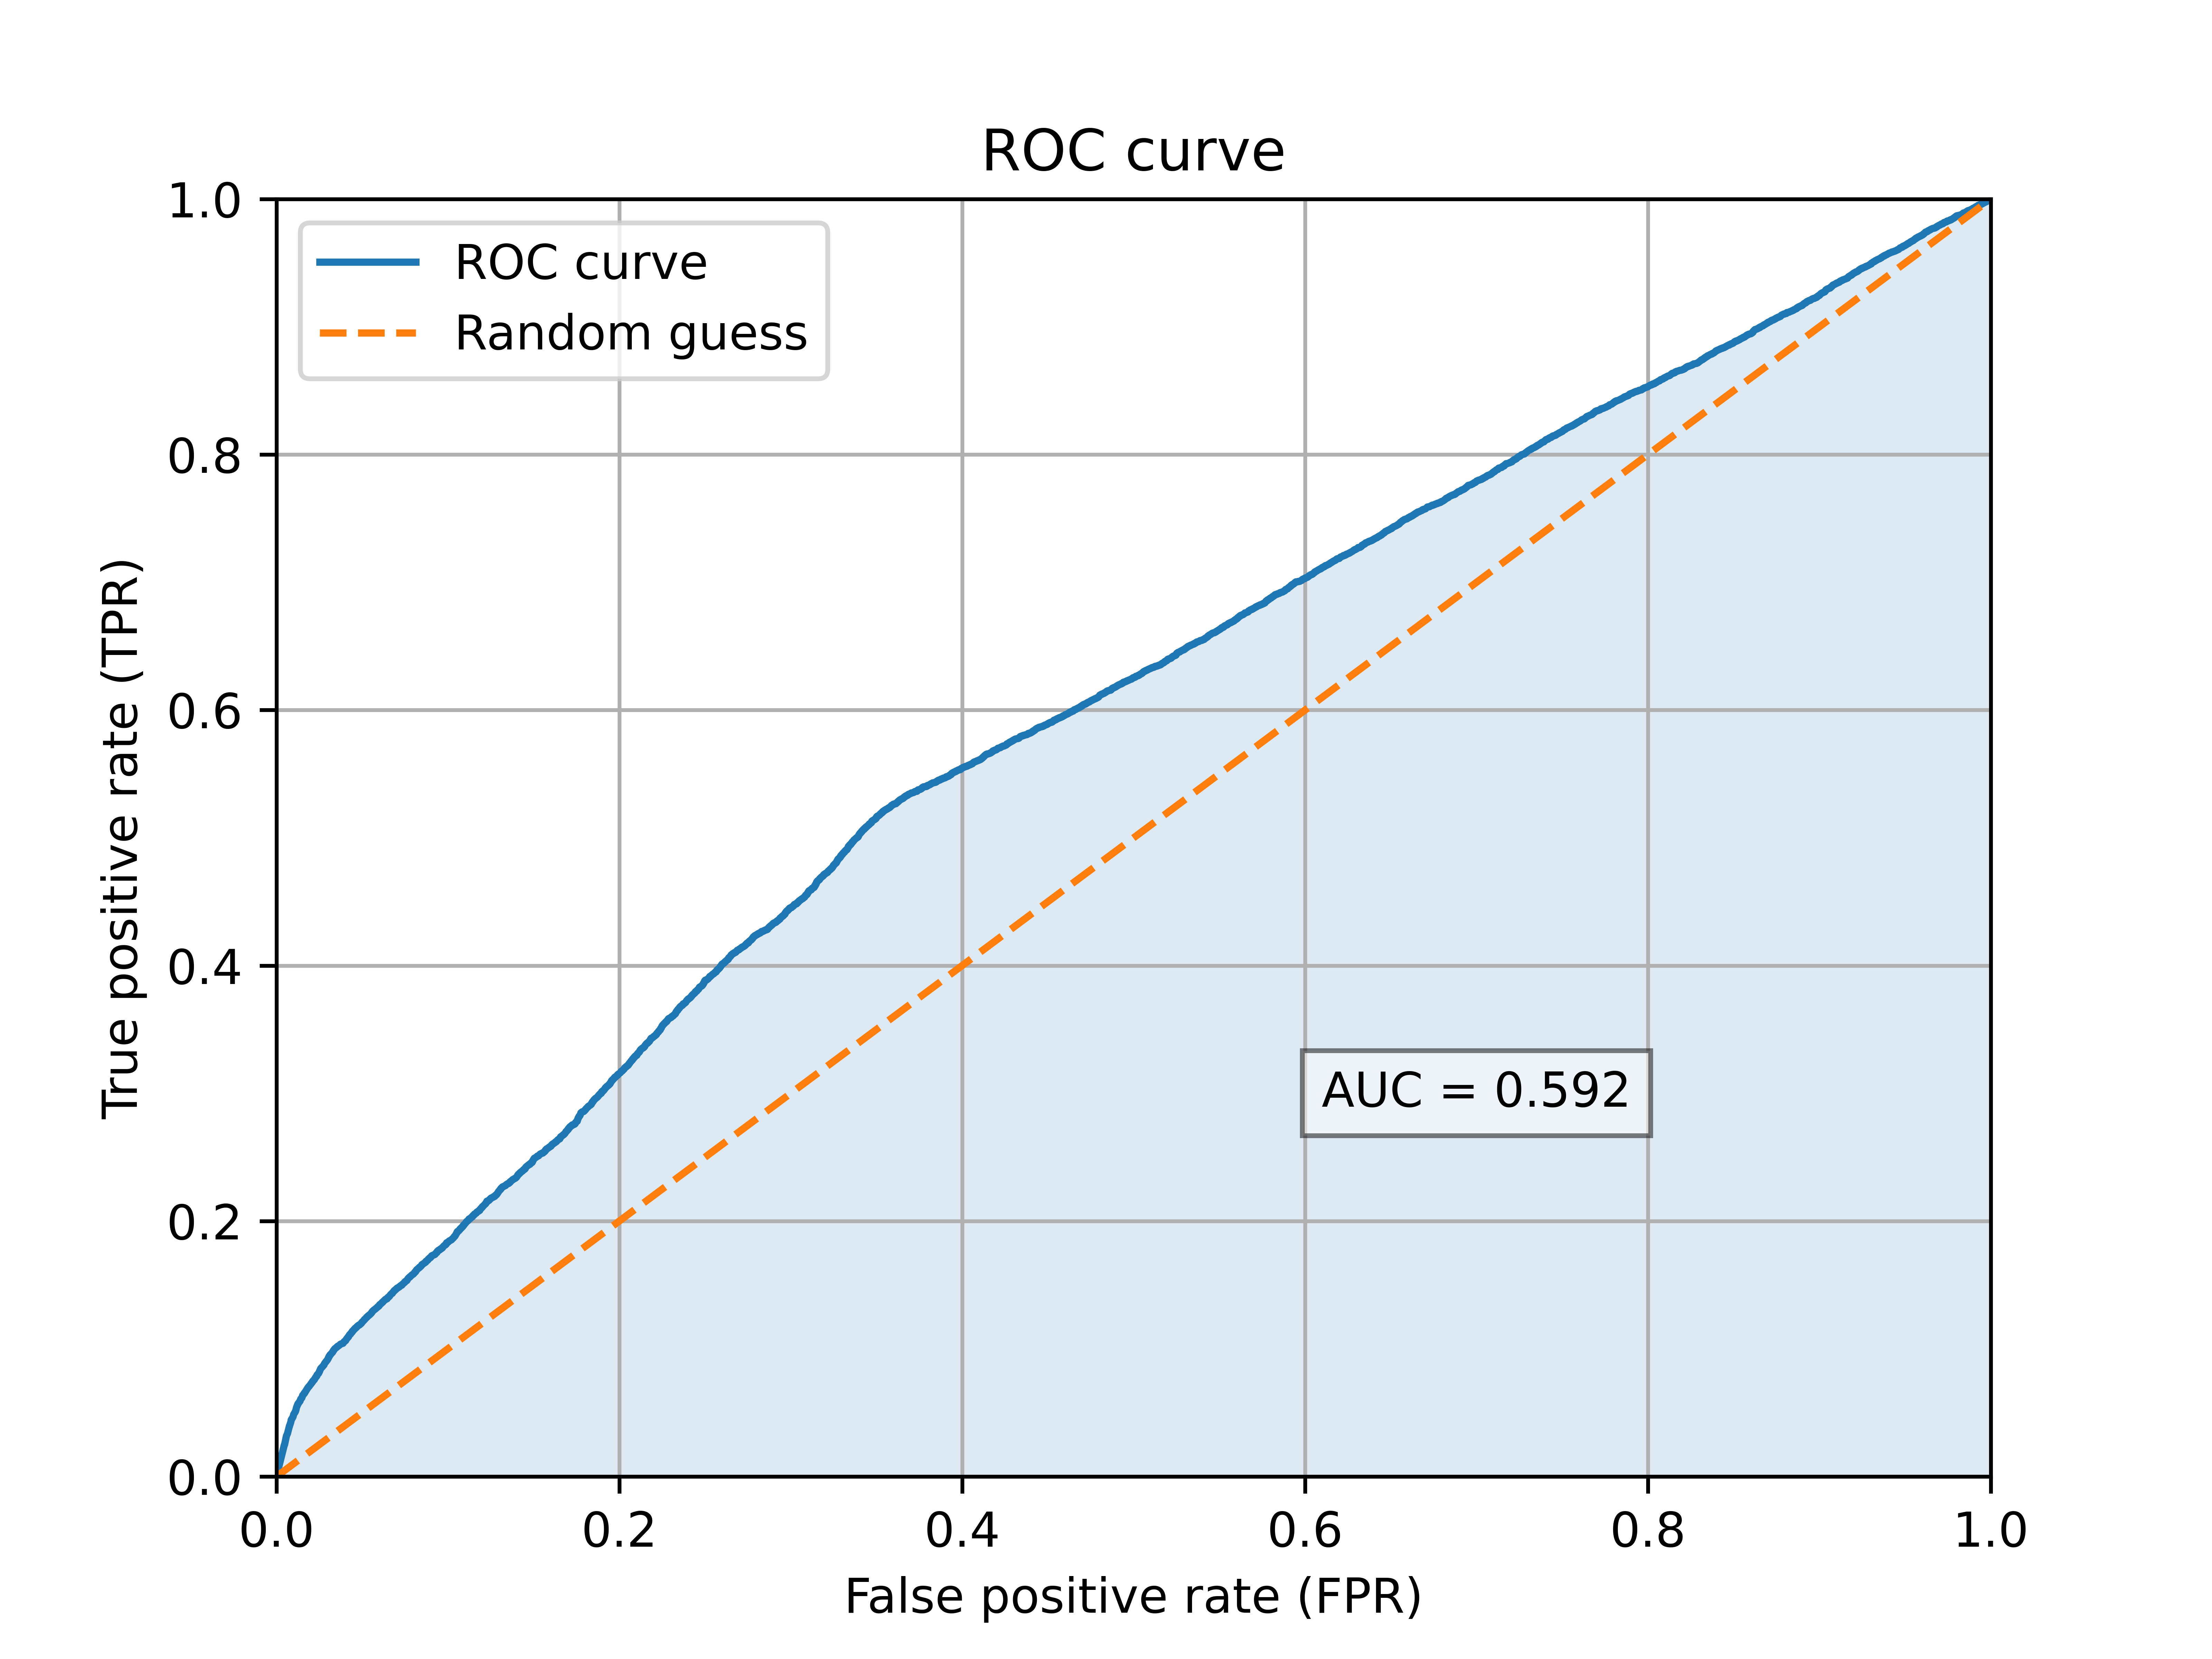

In [10]:
from IPython.display import Image
Image(f"{log_dir}/report_ramia/exp/ROC_0.png")